In [ ]:
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
import torch
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
h = 200
w = 200

data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((h, w)),
                                     transforms.Normalize((0.5,), (0.5,)),
                                     transforms.Grayscale(num_output_channels=3)
    ])
data = datasets.ImageFolder(root='/content/drive/MyDrive/epic/data',
                                           transform=data_transform)
train, val, test = torch.utils.data.random_split(data, [1910, 547, 272])

In [ ]:
train_loader = torch.utils.data.DataLoader(train,
                                             batch_size=30, shuffle=True,
                                             num_workers=2)
val_loader = torch.utils.data.DataLoader(val,
                                             batch_size=30, shuffle=True,
                                             num_workers=2)
test_loader = torch.utils.data.DataLoader(test,
                                             batch_size=30, shuffle=True,
                                             num_workers=2)

###Show a few samples

In [ ]:
print(np.transpose(np.array(data[180][0]),(1,2,0)).shape)

(200, 200, 3)


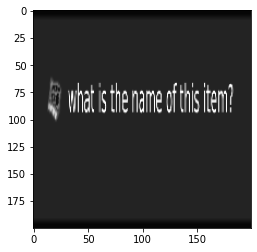

In [ ]:
plt.imshow(np.transpose(np.array(data[499][0]),(1,2,0)))

In [ ]:
labels_map = {
    0: "apple",
    1: "banana",
    2: "chip",
    3: "coin",
    4: "epic coin",
    5: "epic fish",
    6: "zombie eye",
    7: "fish",
    8: "life potion",
    9: "mermaid",
    10: "dragon scale",
    11:"ruby",
    12:"unicorn",
    13:"wolf skin"
}
training_data = train
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(np.transpose(np.array(train[sample_idx][0]),(1,2,0)))
plt.show()

TypeError: ignored

<Figure size 576x576 with 0 Axes>

###Start training

In [ ]:

lr = 1.0
gamma = 0.7
seed = 389
log_interval = 10
save_model = True
use_cuda = torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
from torchvision.models import resnet18
from torch import nn
model = resnet18(num_classes=14) # MNIST has 10 classes
model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from torchvision.models import resnet18
from torch import nn
# Optimizer 
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    loss_list_per_epoch = []
    for batch_idx, (data, target) in enumerate(train_loader):
        
        
        data, target = data.to(device), target.to(device)
        x_train = data
        #print("batch size:",batch_size)
        # reshape data to be of shape batchsize \times 784 #  
        # ------------------------------------------------ # 
        #                                                  #
        # ------------------------------------------------ # 
        #print("data shape:",data.size())

        # set the gradients to zero to avoid unwanted gradient accumulation, see 
        optimizer.zero_grad()
        # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        
        # get model prediction
        y_pred = model(x_train)
        
        # insert you own loss fucntion here, note that we implemented a log_softmax() in our model
        # Can you directly use F.cross_entropy() here? If not, why? 
        
        # Since log is applied to the softmax output, we cannot directly use cross entropy here
        # because F.cross_entropy() is supposed to receive raw model outputs and output CE loss. 
        
        #criterion = torch.nn.NLLLoss()
        criterion = torch.nn.CrossEntropyLoss()
        #print("y_pred:",y_pred)
        #print("target:",target)
        
        
        loss = criterion(y_pred, target)

        # perform back propagation
        loss.backward()
        # update parameters
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        loss_list_per_epoch.append(loss.data)

    return loss_list_per_epoch
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            batch_size = data.size()[0]
            y_pred = model(data)
            criterion = torch.nn.NLLLoss()
            loss = criterion(y_pred, target) 
            test_loss += loss
            #print(np.array(target))
            #print(np.array(np.argmax(y_pred,axis=1)))
            #print(np.sum(np.array(np.argmax(y_pred,axis=1))==np.array(target)))
            y_pred = y_pred.cpu()
            target = target.cpu()
            correct += np.sum(np.array(np.argmax(y_pred,axis=1))==np.array(target))
            #print(np.array(target)==np.array(np.argmax(y_pred,axis=1))
        # ------------------------------------------------ # 
        #                                                  #
        # ------------------------------------------------ #             
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, 100. * correct / len(test_loader.dataset)
#  Let's start training
loss_list = []
val_accuracy_list = []
epochs = 20
losss = []
for epoch in range(1, epochs + 1):
    # train
    print("epoch:",epoch)
    loss_list_per_epoch = train(model, device, train_loader, optimizer, epoch, log_interval)
    # inference on validation set 
    validation_loss, validation_accuracy = test(model, device, val_loader)
    scheduler.step()
    # log loss and acc
    loss_list += loss_list_per_epoch
    val_accuracy_list.append(validation_accuracy)
    losss.append(validation_loss)

    
if save_model:
    torch.save(model.state_dict(), "/content/drive/MyDrive/epic/epic_resnet18.pt")
    # accually you can choose to save the model parameters with the highest 
    # validation accuracy : )

epoch: 1
Train Epoch: 1 [0/1910 (0%)]	Loss: 2.783826
Train Epoch: 1 [300/1910 (16%)]	Loss: 2.817079
Train Epoch: 1 [600/1910 (31%)]	Loss: 2.665967
Train Epoch: 1 [900/1910 (47%)]	Loss: 2.624697
Train Epoch: 1 [1200/1910 (62%)]	Loss: 2.155020
Train Epoch: 1 [1500/1910 (78%)]	Loss: 2.001821
Train Epoch: 1 [1800/1910 (94%)]	Loss: 1.959012

Test set: Average loss: -0.0348, Accuracy: 53/547 (10%)

epoch: 2
Train Epoch: 2 [0/1910 (0%)]	Loss: 2.000205
Train Epoch: 2 [300/1910 (16%)]	Loss: 1.679961
Train Epoch: 2 [600/1910 (31%)]	Loss: 1.832943
Train Epoch: 2 [900/1910 (47%)]	Loss: 1.546590
Train Epoch: 2 [1200/1910 (62%)]	Loss: 1.571516
Train Epoch: 2 [1500/1910 (78%)]	Loss: 1.496862
Train Epoch: 2 [1800/1910 (94%)]	Loss: 1.027368

Test set: Average loss: -0.0939, Accuracy: 173/547 (32%)

epoch: 3
Train Epoch: 3 [0/1910 (0%)]	Loss: 1.878202
Train Epoch: 3 [300/1910 (16%)]	Loss: 1.791109
Train Epoch: 3 [600/1910 (31%)]	Loss: 0.933718
Train Epoch: 3 [900/1910 (47%)]	Loss: 0.947914
Train Epoch: 

In [ ]:
validation_loss, validation_accuracy = test(model, device, test_loader)


Test set: Average loss: -0.3091, Accuracy: 269/272 (99%)



In [ ]:
#modify the test function to record and return the number of correct predictions for each class
def final_test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    number_of_each_class = dict(zip([i for i in range(0,14)],[0]*14))
    number_of_correct_pred = dict(zip([i for i in range(0,14)],[0]*14))
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            batch_size = data.size()[0]
            y_pred = model(data)
            criterion = torch.nn.NLLLoss()
            loss = criterion(y_pred, target) 
            test_loss += loss
            #number of correct predictions
            y_pred = y_pred.cpu()
            target = target.cpu()
            correct += np.sum(np.array(np.argmax(y_pred,axis=1))==np.array(target)) 
            for i in range(0,14):
                mask = np.array(target) == i
                number_of_each_class[i] = number_of_each_class[i] + np.sum(mask)
                result = np.array(np.argmax(y_pred,axis=1))==np.array(target)
                number_of_correct_pred[i] = number_of_correct_pred[i] + np.sum(result[mask])
 
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, 100. * correct / len(test_loader.dataset),number_of_each_class,number_of_correct_pred

In [ ]:
validation_loss, validation_accuracy,a,b = final_test(model, device, test_loader)


Test set: Average loss: -0.3094, Accuracy: 269/272 (99%)



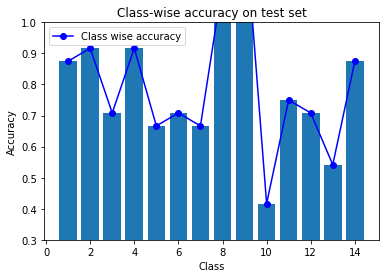

{0: 'apple',
 1: 'banana',
 2: 'chip',
 3: 'coin',
 4: 'epic coin',
 5: 'epic fish',
 6: 'zombie eye',
 7: 'fish',
 8: 'life potion',
 9: 'mermaid',
 10: 'dragon scale',
 11: 'ruby',
 12: 'unicorn',
 13: 'wolf skin'}

In [ ]:
class_wise_accuracy = []
classes = range(1,15)
for i in range(0,14):
    class_i_accuracy = b[i]/a[1]
    class_wise_accuracy.append(class_i_accuracy)
plt.plot(classes,class_wise_accuracy, color='blue',marker='o', label='Class wise accuracy')
plt.bar(classes,class_wise_accuracy)
plt.legend()
plt.title("Class-wise accuracy on test set")
plt.xlabel('Class')
plt.ylim(0.3, 1)
plt.ylabel('Accuracy')        
plt.show()
labels_map

In [ ]:
import cv2
image_path = '/content/drive/MyDrive/epic/new images/2.png'
image_array = cv2.imread(image_path)
image_tensor = data_transform(image_array)

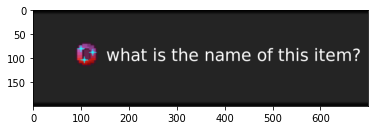

In [ ]:
plt.imshow(image_array)

In [ ]:
image_array.shape

(200, 700, 3)

In [ ]:
res = resnet18(num_classes=14)
res.load_state_dict(torch.load('/content/drive/MyDrive/epic/epic_resnet18.pt'))
res.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
tf.shape(image_tensor)

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([  3, 200, 200], dtype=int32)>

tensor([[[-0.9450, -0.9450, -0.9450,  ..., -0.9450, -0.9450, -0.9450],
         [-0.9450, -0.9450, -0.9450,  ..., -0.9450, -0.9450, -0.9450],
         [-0.9450, -0.9450, -0.9450,  ..., -0.9450, -0.9450, -0.9450],
         ...,
         [-0.9450, -0.9450, -0.9450,  ..., -0.9450, -0.9450, -0.9450],
         [-0.9450, -0.9450, -0.9450,  ..., -0.9450, -0.9450, -0.9450],
         [-0.9450, -0.9450, -0.9450,  ..., -0.9450, -0.9450, -0.9450]],

        [[-0.9450, -0.9450, -0.9450,  ..., -0.9450, -0.9450, -0.9450],
         [-0.9450, -0.9450, -0.9450,  ..., -0.9450, -0.9450, -0.9450],
         [-0.9450, -0.9450, -0.9450,  ..., -0.9450, -0.9450, -0.9450],
         ...,
         [-0.9450, -0.9450, -0.9450,  ..., -0.9450, -0.9450, -0.9450],
         [-0.9450, -0.9450, -0.9450,  ..., -0.9450, -0.9450, -0.9450],
         [-0.9450, -0.9450, -0.9450,  ..., -0.9450, -0.9450, -0.9450]],

        [[-0.9450, -0.9450, -0.9450,  ..., -0.9450, -0.9450, -0.9450],
         [-0.9450, -0.9450, -0.9450,  ..., -0

In [ ]:
image_tensor1 = torch.unsqueeze(image_tensor,0)

In [ ]:
labels_map = {
    0: "apple",
    1: "banana",
    2: "chip",
    3: "coin",
    4: "epic coin",
    5: "epic fish",
    6: "zombie eye",
    7: "fish",
    8: "life potion",
    9: "mermaid",
    10: "dragon scale",
    11:"ruby",
    12:"unicorn",
    13:"wolf skin"
}

In [ ]:
labels_map[np.argmax(res(image_tensor1).detach().numpy())]

'epic coin'

ruby
coin
epic coin


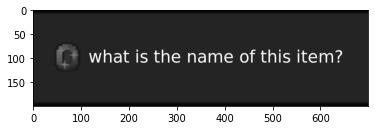

In [ ]:
import cv2
image_path = '/content/drive/MyDrive/epic/new images/epic_guard-38.png'
image_array = cv2.imread(image_path)
image_tensor = data_transform(image_array)
plt.imshow(image_array)
image_tensor1 = torch.unsqueeze(image_tensor,0)
for i in list(np.argsort(res(image_tensor1).detach().numpy())[0][-3:]):
  print(labels_map[i])